# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa).**

Datos: los datos con los que vamos a trabajar corresponden a Buenos Aires Data, que como indican en su sitio web, son datos *públicos*, generados, guardados y publicados por el Gobierno de la Ciudad Autónoma de Buenos Aires.

En el sitio se pueden encontrar todo tipo de datasets, referentes a temas de salud, ambientales, transporte público, finanzas, género, urbanismo y más.

En este caso estamos trabajando con datos de flujo vehicular en autopistas, también podemos encontrar datasets de flujo vehicular en avenidas y accesos (los datos son captados por los detectores de patentes).

En este notebook vamos a estudiar el flujo vehicular en la autopista Illia, uno de los accesos más usados para llegar a la zona de centro, microcentro y portuaria.

### 1. Preparación del Dataset

In [2]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 214 kB 16.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640321 sha256=9f2d56b7c07e124146750db38346438e90e111161b12a783ad354fb13c67aef4
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from prophet import Prophet

In [4]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Vamos a hacer un "*pantallazo*" de los datos. Vamos a ver cantidad de filas, columnas, chequear nulos, ver qué tipo de dato tenemos en cada una de las columnas.

In [5]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [6]:
print(data_2019.describe())
data_2019.tail()

        periodo    hora_inicio       hora_fin  cantidad_pasos
count  812153.0  812153.000000  812153.000000   812153.000000
mean     2019.0      11.877101      11.957619      156.018047
std         0.0       6.676295       6.733530      387.348842
min      2019.0       0.000000       0.000000        1.000000
25%      2019.0       6.000000       7.000000        4.000000
50%      2019.0      12.000000      12.000000       15.000000
75%      2019.0      18.000000      18.000000       72.000000
max      2019.0      23.000000      23.000000     6677.000000


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7
812152,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,TELEPASE,7


In [7]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [8]:
print(data_2018.describe())
data_2018.tail()

         periodo   hora_inicio      hora_fin  cantidad_pasos
count  1375908.0  1.375908e+06  1.375908e+06    1.375908e+06
mean      2018.0  1.198040e+01  1.211807e+01    8.946361e+01
std          0.0  6.538943e+00  6.610977e+00    2.910907e+02
min       2018.0  0.000000e+00  0.000000e+00    1.000000e+00
25%       2018.0  7.000000e+00  7.000000e+00    2.000000e+00
50%       2018.0  1.200000e+01  1.200000e+01    6.000000e+00
75%       2018.0  1.700000e+01  1.800000e+01    2.600000e+01
max       2018.0  2.300000e+01  2.300000e+01    5.722000e+03


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
1375903,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,62
1375904,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1375905,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3
1375906,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,13
1375907,2018,2018-12-31,23,0,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3


In [9]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [10]:
print(data_2017.describe())
data_2017.tail()

         periodo   hora_inicio      hora_fin  cantidad_pasos
count  1372645.0  1.372645e+06  1.372645e+06    1.372645e+06
mean      2017.0  1.197077e+01  1.210050e+01    9.094375e+01
std          0.0  6.571334e+00  6.641892e+00    3.016382e+02
min       2017.0  0.000000e+00  0.000000e+00    1.000000e+00
25%       2017.0  7.000000e+00  7.000000e+00    2.000000e+00
50%       2017.0  1.200000e+01  1.200000e+01    7.000000e+00
75%       2017.0  1.700000e+01  1.800000e+01    2.800000e+01
max       2017.0  2.300000e+01  2.300000e+01    4.271000e+03


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1
1372644,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,4


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [11]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [12]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [13]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [14]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**

Dado que se determinó que la forma de pago `telepase` iba a pasar a ser prácticamente obligatoria a partir del año 2020. La implementación de dicha medida consiste en que los conductores que no usen el `telepase` para circular iban a pagar una tarifa del DOBLE. Creo que estudiar solo efectivo como forma de pago podría sesgar nuestro análisis. [Fuente](https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el)

In [15]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia
dataset = dataset[dataset.estacion=='Illia']

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo', 'hora_fin', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_inicio,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
19,2019-01-01,0,Martes,Centro,Liviano,NO COBRADO,146
20,2019-01-01,0,Martes,Centro,Liviano,TELEPASE,59
21,2019-01-01,0,Martes,Centro,Pesado,TELEPASE,1
22,2019-01-01,0,Martes,Provincia,Liviano,NO COBRADO,147
23,2019-01-01,0,Martes,Provincia,Liviano,TELEPASE,106


En el notebook original tomabanmos `hora_fin` como hora, pero mas adelante en el analisis comprendí que generaba confusión la hora 0 y el cambio de fecha, así que resolví que era mejor tomar `hora_inicio`, para que siempre la hora 0 coincida con su respectiva fecha

In [16]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_inicio como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_inicio, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha'], inplace = True)

dataset.head()

,hora_inicio,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
19,0,Martes,Centro,Liviano,NO COBRADO,146,2019-01-01
20,0,Martes,Centro,Liviano,TELEPASE,59,2019-01-01
21,0,Martes,Centro,Pesado,TELEPASE,1,2019-01-01
22,0,Martes,Provincia,Liviano,NO COBRADO,147,2019-01-01
23,0,Martes,Provincia,Liviano,TELEPASE,106,2019-01-01


In [17]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,hora_inicio,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
19,0,Martes,Centro,Liviano,NO COBRADO,146,2019-01-01
20,0,Martes,Centro,Liviano,TELEPASE,59,2019-01-01
21,0,Martes,Centro,Pesado,TELEPASE,1,2019-01-01
22,0,Martes,Provincia,Liviano,NO COBRADO,147,2019-01-01
23,0,Martes,Provincia,Liviano,TELEPASE,106,2019-01-01


In [18]:
#Reordenamos el dataset por fecha
dataset.sort_values(['fecha'], inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,hora_inicio,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,0,Domingo,Centro,Liviano,NO COBRADO,252,2017-01-01 00:00:00
1,0,Domingo,Centro,Liviano,EFECTIVO,1,2017-01-01 00:00:00
2,0,Domingo,Centro,Liviano,TELEPASE,100,2017-01-01 00:00:00
3,0,Domingo,Centro,Pesado,TELEPASE,2,2017-01-01 00:00:00
4,0,Domingo,Centro,Pesado,TELEPASE,1,2017-01-01 00:00:00
...,...,...,...,...,...,...,...
752547,23,Martes,Centro,Liviano,TELEPASE,39,2019-12-31 23:00:00
752548,23,Martes,Centro,Pesado,TELEPASE,2,2019-12-31 23:00:00
752549,23,Martes,Provincia,Liviano,NO COBRADO,145,2019-12-31 23:00:00
752550,23,Martes,Provincia,Liviano,TELEPASE,26,2019-12-31 23:00:00


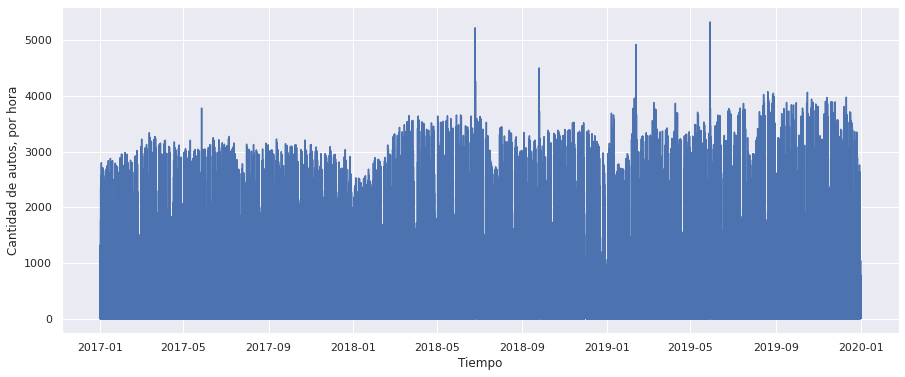

In [19]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Este dataset esta arreglado por cabina de peaje. Como nuestro análisis no se va a enfocar en estudiar cada cabina por separado, vamos a intentar llevarlo a un registro por hora. Vamos a tirar las columnas `tipo_vehículo`, `forma_pago` y `sentido`. Si bien `sentido` nos aporta información sobre el horario en el cual ocurrirá el pico de flujo (si es centro será por la mañana y si es provincia será por la tarde), es información de la cual podemos prescindir, y trabajar con dos picos de flujo diarios.

In [20]:
dataset.drop(columns=['tipo_vehiculo','forma_pago', 'sentido'])
hourly = dataset.groupby(by=['fecha', 'hora_inicio', 'dia']).sum()
hourly.reset_index(inplace=True)
hourly

,fecha,hora_inicio,dia,cantidad_pasos
0,2017-01-01 00:00:00,0,Domingo,598
1,2017-01-01 01:00:00,1,Domingo,2222
2,2017-01-01 02:00:00,2,Domingo,2632
3,2017-01-01 03:00:00,3,Domingo,1780
4,2017-01-01 04:00:00,4,Domingo,794
...,...,...,...,...
26264,2019-12-31 19:00:00,19,Martes,2811
26265,2019-12-31 20:00:00,20,Martes,3701
26266,2019-12-31 21:00:00,21,Martes,2438
26267,2019-12-31 22:00:00,22,Martes,657


Ahora que ya convertimos el dataset en una serie de tiempo, vamos a ver como es el comportamiento para cada día de la semana y así mismo para cada hora del día.

Text(0.5, 1.0, 'Cantidad de autos promedio para cada hora del día')

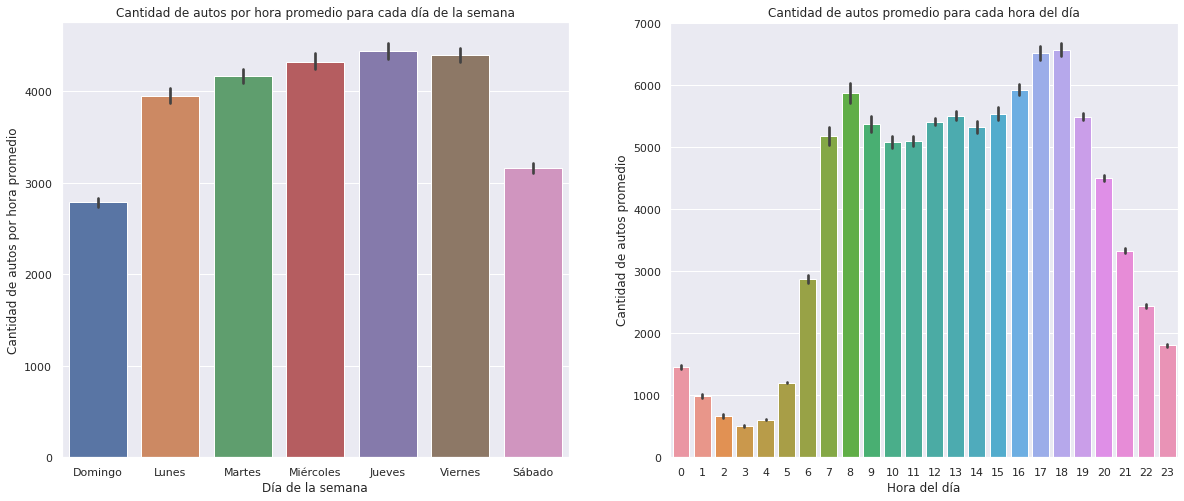

In [21]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(data=hourly, x='dia', y='cantidad_pasos')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de autos por hora promedio')
plt.title('Cantidad de autos por hora promedio para cada día de la semana')

plt.subplot(1,2,2)
sns.barplot(data=hourly, x='hora_inicio', y='cantidad_pasos')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de autos promedio')
plt.title('Cantidad de autos promedio para cada hora del día')

Podemos observar que el flujo "pico" corresponde a los horarios y días hábiles, donde la mayoría de las personas se traslada hacia el centro(el peaje estudiado corresponde a uno de los accesos a la zona de Microcentro de la Ciudad de Buenos Aires, donde se desarrolla gran parte de la actividad económica de la Ciudad).

Vamos a graficar la serie:

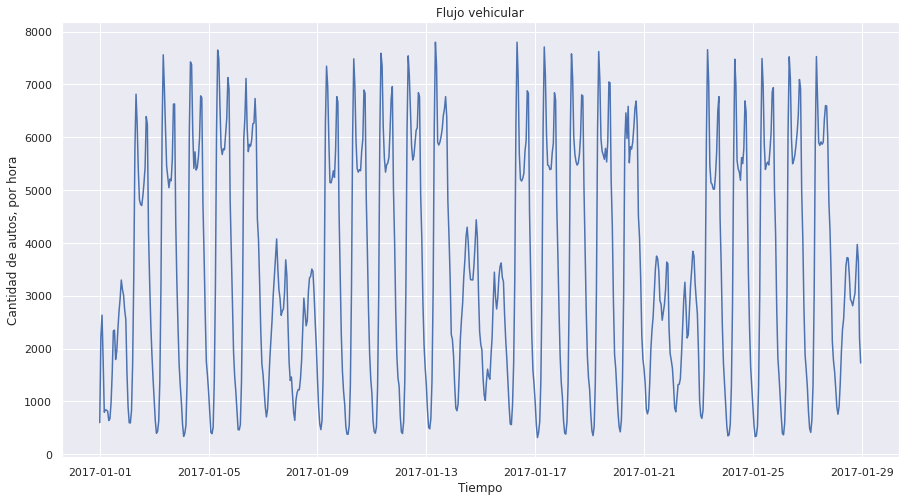

In [22]:
plt.figure(figsize = (15,8))
plt.plot(hourly.fecha[:48*14], hourly.cantidad_pasos[:48*14])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.title('Flujo vehicular')
plt.show()

El gráfico que tenemos arriba es una especie de "zoom" que le hacemos a la serie. El objetivo es visualizar la estacionalidad horaria, que si se puede apreciar de esta forma.

Ahora graficamos la serie completa:

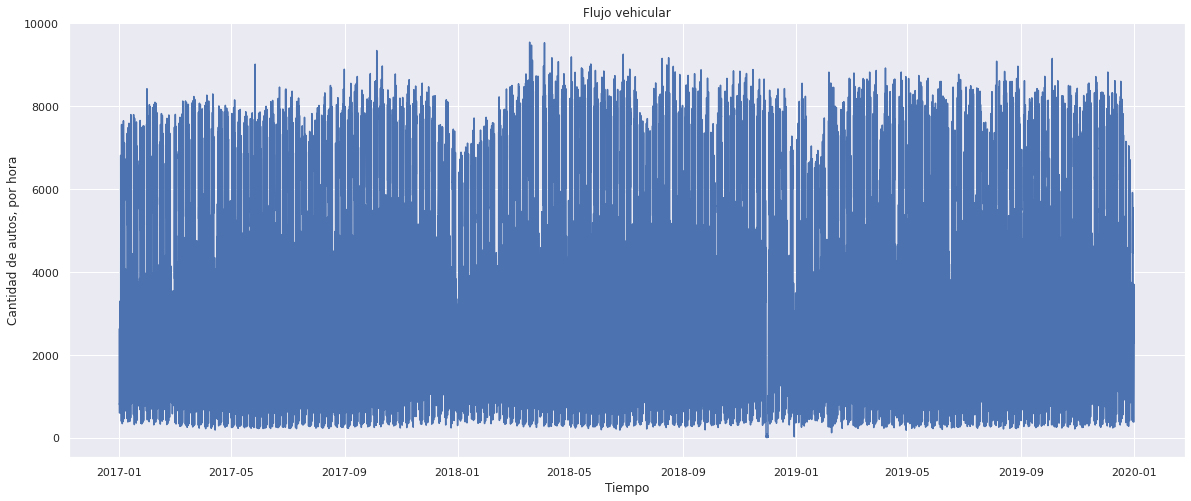

In [23]:
plt.figure(figsize = (20,8))
plt.plot(hourly.fecha, hourly.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.title('Flujo vehicular')
plt.show()

En principio no se logra visualizar ninguna tendecia *obvia*

Antes de continuar, necesitamos ver los outliers y chequear que no tengamos "gaps" en nuestra serie.

In [24]:
hourly[['cantidad_pasos']].describe()

,cantidad_pasos
count,26269.000000
mean,3891.118390
std,2471.148685
min,2.000000
25%,1498.000000
50%,3753.000000
75%,6169.000000
max,9548.000000


In [25]:
q25,q75 = np.quantile(hourly.cantidad_pasos, q=[0.25, 0.75])
iqr = q75 - q25
minimo = q25 - (1.5*iqr)
maximo = q75 + (1.5*iqr)
print(q25,q75,iqr, minimo, maximo)

1498.0 6169.0 4671.0 -5508.5 13175.5


Calculamos los estadísticos y aplicamos la regla del rango intercuartílico para chequear que no haya outliers en esta serie.

In [26]:
(24*365*3) - hourly.shape[0]

11

Con ese sencillo cálculo determine la cantidad de horas que hay en 3 años(primero verificando que 2017, 2018 y 2019 no hayan sido bisiestos), y restandole la cantidad de instancias que tenemos en el dataset nos da la cantidad de registros que nos estarían faltando.

In [27]:
hourly.set_index('fecha', inplace=True)
hourly = hourly.asfreq(freq='H')
hourly.isna().sum()

hora_inicio       11
dia               11
cantidad_pasos    11
dtype: int64

Excelente! Nos faltaban exactamente 11 registros y ahora tenemos la serie equiespaciada, sin gaps, solo tenemos que rellenar los `np.nan`.

In [28]:
hourly.reset_index(inplace=True)
hourly[hourly['cantidad_pasos'].isna()]

,fecha,hora_inicio,dia,cantidad_pasos
16750,2018-11-29 22:00:00,NaN,NaN,NaN
16751,2018-11-29 23:00:00,NaN,NaN,NaN
16752,2018-11-30 00:00:00,NaN,NaN,NaN
16753,2018-11-30 01:00:00,NaN,NaN,NaN
16754,2018-11-30 02:00:00,NaN,NaN,NaN
16755,2018-11-30 03:00:00,NaN,NaN,NaN
16756,2018-11-30 04:00:00,NaN,NaN,NaN
16757,2018-11-30 05:00:00,NaN,NaN,NaN
16758,2018-11-30 06:00:00,NaN,NaN,NaN
16779,2018-12-01 03:00:00,NaN,NaN,NaN


Hice un poco de investigación y descubrí que estas filas faltantes correspondían a la cumbre del G20 que se realizó en la ciudad de Buenos Aires en el año 2018. [Fuente.](https://www.buenosaires.gob.ar/jefedegobierno/xiii-cumbre-lideres-g20/cumbre-del-g20-viernes-30-de-noviembre)

Dado que es un suceso atípico que no se repite con regularidad, vamos a tratarlo como si fueran valores faltantes MCAR, es decir sin motivo aparente, y los vamos a rellenar con el promedio para su respectivo día de la semana, a su respectiva hora. Es decir, con la cantidad promedio de vehículos que pasan, por ejemplo, los viernes a las 22.00 hs.

Al ser solamente 11 registros para rellenar, lo voy a hacer de forma manual

In [29]:
hourly.iloc[16750:16752,2] = 'Jueves'
hourly.iloc[16752:16759,2] = 'Viernes'
hourly.iloc[16779,2] = 'Sábado'
hourly.iloc[17479,2] = 'Domingo'

In [30]:
hourly.iloc[16750:16752,1] = 22, 23
hourly.iloc[16752:16759,1] = 0, 1, 2, 3, 4, 5, 6
hourly.iloc[16779,1] = 3
hourly.iloc[17479,1] = 7

In [31]:
dicc = hourly.groupby(by=['dia','hora_inicio']).mean()
dicc['cantidad_pasos'] = dicc['cantidad_pasos'].apply(lambda x: int(x))
dicc = dicc.to_dict()
dicc

{'cantidad_pasos': {('Domingo', 0.0): 1964,
  ('Domingo', 1.0): 1756,
  ('Domingo', 2.0): 1341,
  ('Domingo', 3.0): 875,
  ('Domingo', 4.0): 740,
  ('Domingo', 5.0): 1020,
  ('Domingo', 6.0): 1431,
  ('Domingo', 7.0): 1804,
  ('Domingo', 8.0): 1979,
  ('Domingo', 9.0): 2271,
  ('Domingo', 10.0): 2771,
  ('Domingo', 11.0): 3489,
  ('Domingo', 12.0): 4248,
  ('Domingo', 13.0): 3867,
  ('Domingo', 14.0): 3227,
  ('Domingo', 15.0): 3528,
  ('Domingo', 16.0): 4256,
  ('Domingo', 17.0): 4778,
  ('Domingo', 18.0): 4877,
  ('Domingo', 19.0): 4631,
  ('Domingo', 20.0): 4126,
  ('Domingo', 21.0): 3287,
  ('Domingo', 22.0): 2662,
  ('Domingo', 23.0): 1981,
  ('Jueves', 0.0): 1394,
  ('Jueves', 1.0): 763,
  ('Jueves', 2.0): 431,
  ('Jueves', 3.0): 363,
  ('Jueves', 4.0): 528,
  ('Jueves', 5.0): 1248,
  ('Jueves', 6.0): 3468,
  ('Jueves', 7.0): 6640,
  ('Jueves', 8.0): 7443,
  ('Jueves', 9.0): 6540,
  ('Jueves', 10.0): 5993,
  ('Jueves', 11.0): 5748,
  ('Jueves', 12.0): 5946,
  ('Jueves', 13.0): 62

In [32]:
hourly.set_index(['dia','hora_inicio'], inplace=True)
hourly['cantidad_pasos'] = hourly['cantidad_pasos'].fillna(dicc['cantidad_pasos'])

In [33]:
print(hourly.isna().sum())
hourly.reset_index(inplace=True)
hourly.drop(columns=['hora_inicio'], inplace=True)

fecha             0
cantidad_pasos    0
dtype: int64


A continuación vamos a estudiar la autocorrelación, para intentar definir cuantos registros debemos tomar para predecir uno.

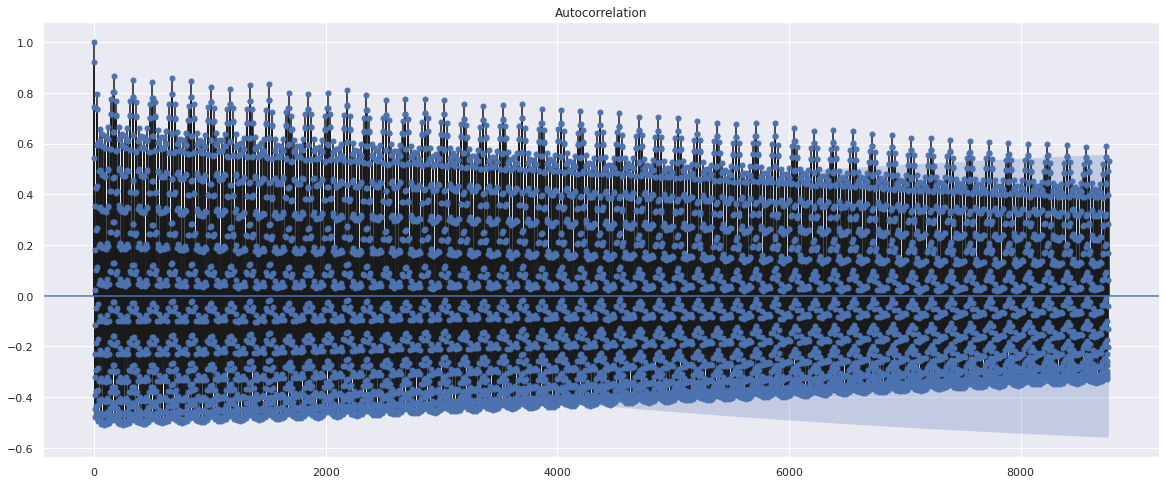

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_acf(hourly.cantidad_pasos, lags =24*365, ax = ax)
plt.show()

Interpretando este gráfico podemos ver que el área sombreada resultó pequeña, lo cual nos indica que, para este dataset de registros horarios, necesitariamos demasiada data para predecir un solo registro. Ahora intentaremos reducir esto resampleando la serie de forma diaria, semanal y mensual. Repetiremos el gráfico para todas ellas y en base a él, y considerando el tamaño del dataset, haremos la elección de frecuencia para trabajar.

In [35]:
daily = hourly.resample('D', on = 'fecha').sum()
daily

,cantidad_pasos
fecha,
2017-01-01,45478.0
2017-01-02,89289.0
2017-01-03,92602.0
2017-01-04,95813.0
2017-01-05,100044.0
...,...
2019-12-27,101501.0
2019-12-28,60999.0
2019-12-29,50185.0


In [36]:
daily.describe()

,cantidad_pasos
count,1095.000000
mean,93361.799087
std,20958.608685
min,1827.000000
25%,74798.000000
50%,101319.000000
75%,109624.500000
max,125519.000000


In [37]:
q25,q75 = np.quantile(daily.cantidad_pasos, q=[0.25, 0.75])
iqr = q75 - q25
minimo = q25 - (1.5*iqr)
maximo = q75 + (1.5*iqr)
print(q25,q75,iqr, minimo, maximo)

74798.0 109624.5 34826.5 22558.25 161864.25


In [38]:
daily.reset_index(inplace=True)
for i in np.arange(daily.shape[0]):
  if daily.iloc[i,1] < minimo:
    daily.iloc[i,1] = np.nan

daily.set_index('fecha', inplace=True)
daily.isna().sum()

cantidad_pasos    2
dtype: int64

In [39]:
daily[daily['cantidad_pasos'].isna()]

,cantidad_pasos
fecha,
2018-11-30,NaN
2018-12-01,NaN


In [40]:
daily['cantidad_pasos'] = daily['cantidad_pasos'].fillna(int(daily.cantidad_pasos.mean()))
daily.isna().sum()

cantidad_pasos    0
dtype: int64

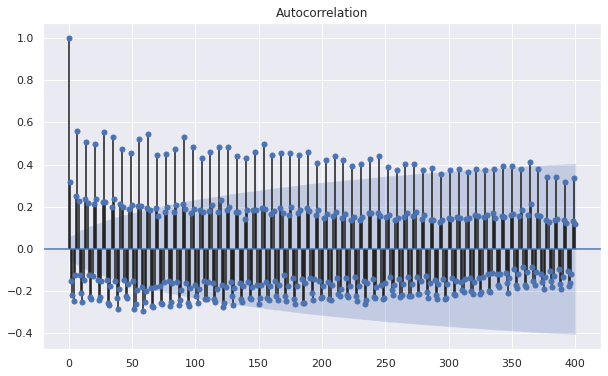

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(daily.cantidad_pasos, lags = 400, ax=ax)
plt.show()

En este gráfico vemos que para predecir día a día, necesitaríamos un lookback de casi 300 días.

In [42]:
weekly = hourly.resample('W', on='fecha').sum()
weekly

,cantidad_pasos
fecha,
2017-01-01,45478.0
2017-01-08,585700.0
2017-01-15,613675.0
2017-01-22,599307.0
2017-01-29,598163.0
...,...
2019-12-08,707644.0
2019-12-15,658014.0
2019-12-22,724497.0


In [43]:
weekly.describe()

,cantidad_pasos
count,158.000000
mean,647032.721519
std,82557.708626
min,45478.000000
25%,622593.000000
50%,658090.500000
75%,696007.750000
max,744460.000000


In [44]:
q25,q75 = np.quantile(weekly.cantidad_pasos, q=[0.25, 0.75])
iqr = q75 - q25
minimo = q25 - (1.5*iqr)
maximo = q75 + (1.5*iqr)
print(q25,q75,iqr, minimo, maximo)

622593.0 696007.75 73414.75 512470.875 806129.875


In [45]:
weekly.reset_index(inplace=True)
for i in np.arange(weekly.shape[0]):
  if weekly.iloc[i,1] < minimo:
    weekly.iloc[i,1] = np.nan

weekly.set_index('fecha', inplace=True)
weekly.isna().sum()

cantidad_pasos    3
dtype: int64

In [46]:
weekly['cantidad_pasos'] = weekly['cantidad_pasos'].fillna(int(weekly.cantidad_pasos.mean()))
weekly.isna().sum()

cantidad_pasos    0
dtype: int64

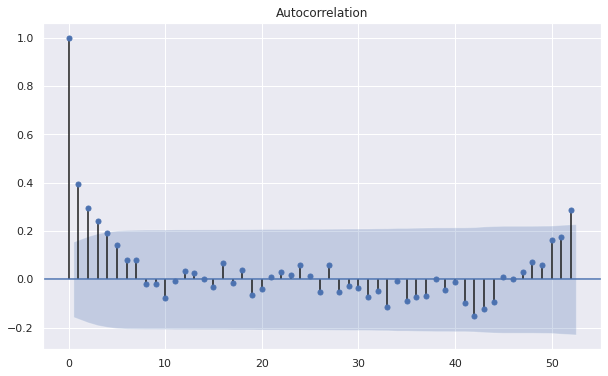

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(weekly.cantidad_pasos, lags = 52, ax=ax)
plt.show()

En este otro gráfico, si bien casi todas las semanas del año no tienen correlación demasiado alta, nuestro lookback seguiría siendo de 1 año, porque tenemos la misma semana un año después dentro del intervalo de confianza.

In [48]:
monthly = hourly.resample('M', on='fecha').sum()
monthly

,cantidad_pasos
fecha,
2017-01-31,2639365.0
2017-02-28,2364688.0
2017-03-31,2734740.0
2017-04-30,2629246.0
2017-05-31,2756833.0
2017-06-30,2726986.0
2017-07-31,2827076.0
2017-08-31,2921152.0
2017-09-30,2935394.0


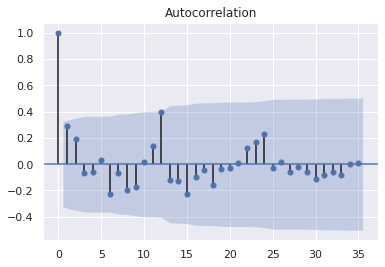

In [49]:
plot_acf(monthly.cantidad_pasos, lags = 35)
plt.show()

En este último gráfico podemos descartar el dataset mensual, dado que prácticamente no existe correlación entre los meses, y tomamos todo el dataset para graficarlo.

Creo que el mejor dataset para trabajar va a ser el resampleado de forma diaria, aunque no descarto el semanal todavía, pero un dataset de 1000 instancias es un buen número para trabajar, y el lookback es el mismo que el semanal.

Calculamos las tendencias:

In [50]:
ventana = int(weekly.shape[0]/4)
tendencia = weekly.cantidad_pasos.rolling(window=ventana, center=True).mean()

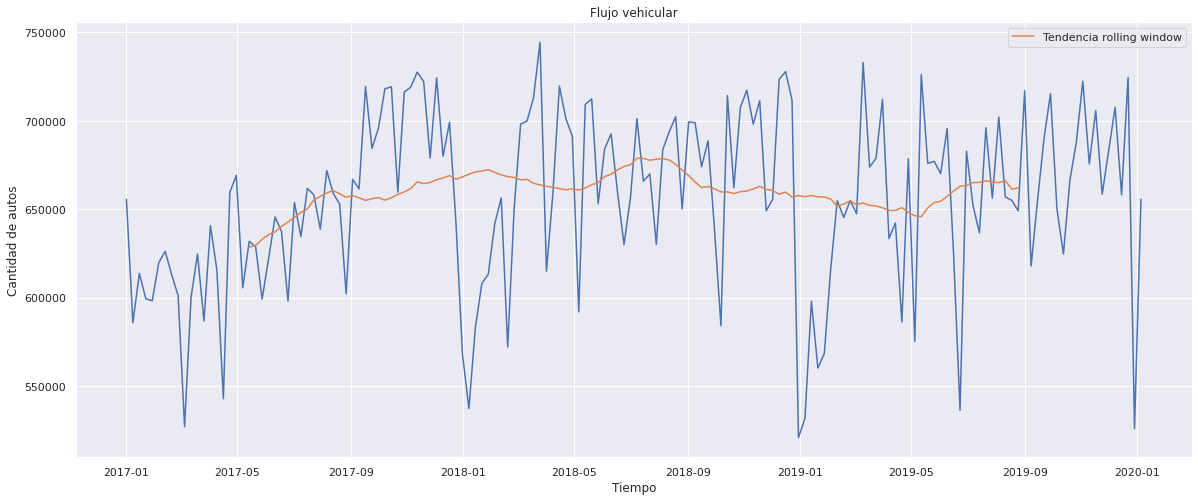

In [51]:
plt.figure(figsize = (20,8))

plt.plot(weekly.index, weekly.cantidad_pasos)
plt.plot(tendencia, label='Tendencia rolling window')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Flujo vehicular')

plt.legend()
plt.show()

In [52]:
ventana = int(daily.shape[0]/7)
tendencia = daily.cantidad_pasos.rolling(window=ventana, center=True).mean()

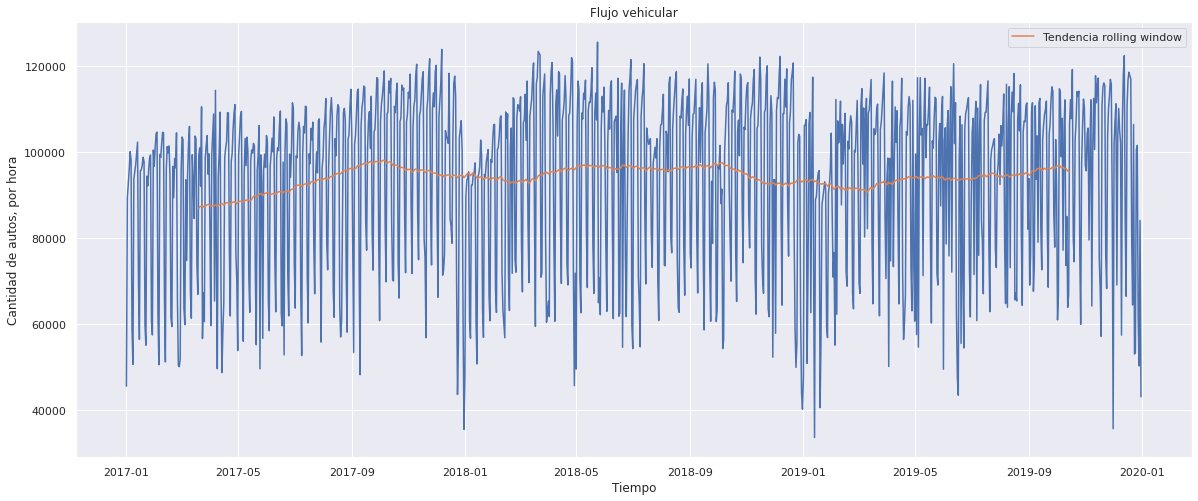

In [53]:
plt.figure(figsize = (20,8))

plt.plot(daily.index, daily.cantidad_pasos)
plt.plot(tendencia, label='Tendencia rolling window')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.title('Flujo vehicular')

plt.legend()
plt.show()

Tenemos entonces dos gráficos con los datos observados y las tendencias calculadas con el método *rolling window*, es decir una media móvil. No se logra visualizar si estas son ascendentes, descendentes o estáticas, así que vamos a probar con otro método más completo.
### **SEASONAL DECOMPOSE**
Para terminar de decidir que frecuencia usar vamos a calcular `seasonal_decompose`, para observar la tendencia y los errores.

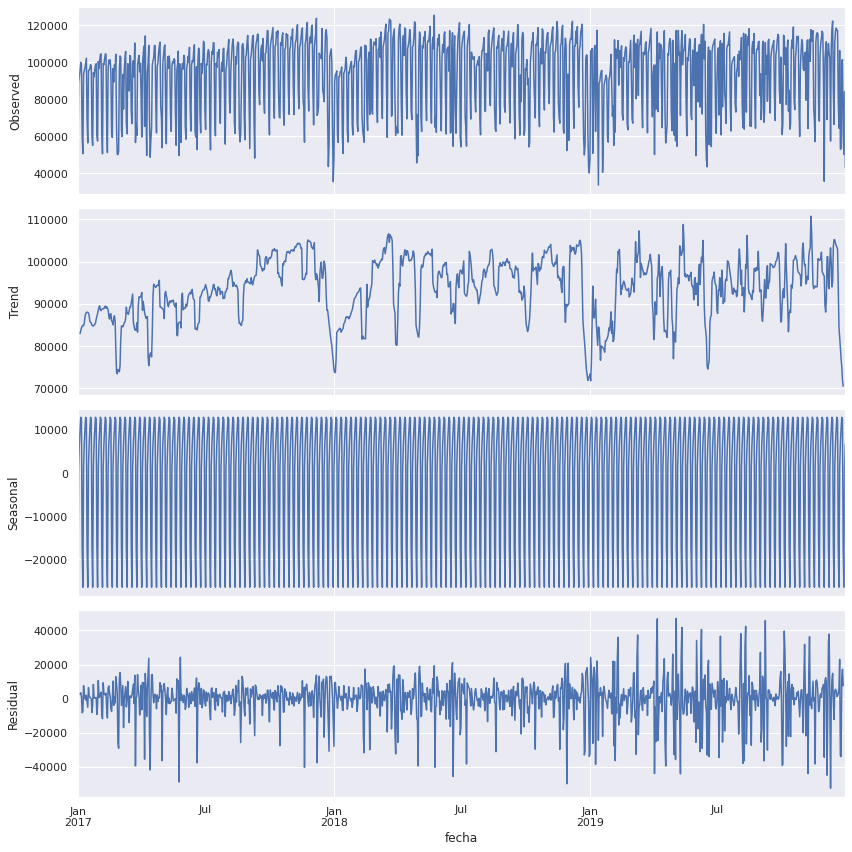

In [54]:
result = seasonal_decompose(daily.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

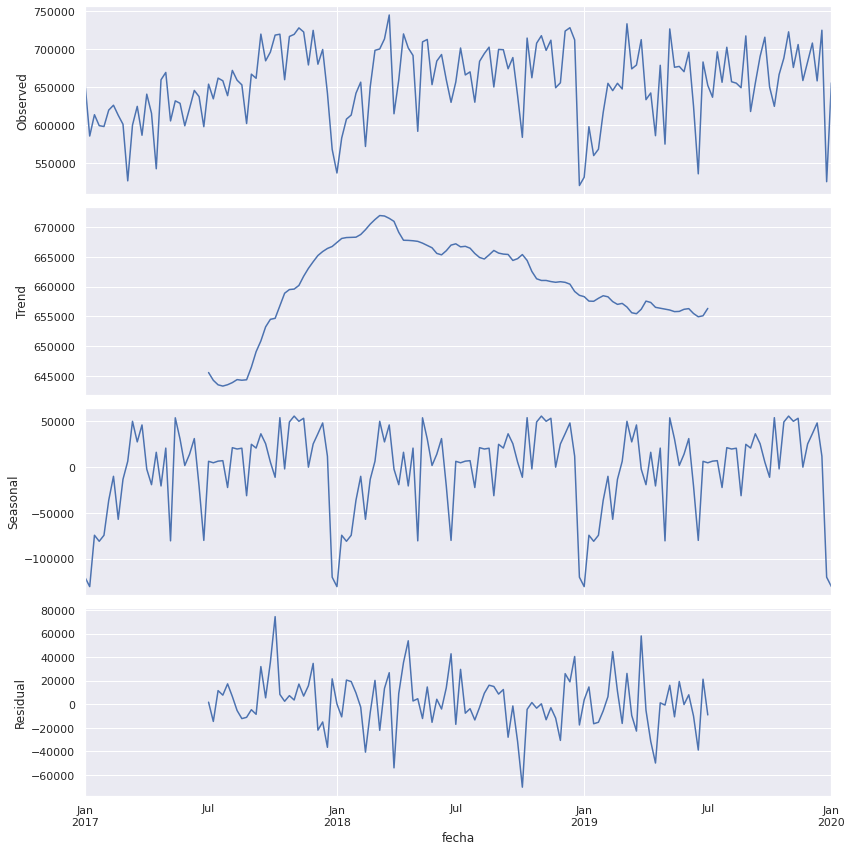

In [55]:
result = seasonal_decompose(weekly.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

Interpretando brevemente estos gráficos, señalo dos puntos que creo que son claves para la elección: si bien en el gráfico diario podemos ver el componente estacional bien definido, lo cual nos haría inclinarnos por esa serie, debemos prestar atencion al componente residual: en la serie diaria, vemos que se concentra demasiado sobre el final de la serie, que es, precisamente, el período sobre el cual vamos a predecir. En cambio, en la serie semanal tenemos una distribución de errores aleatoria. Por lo tanto, vamos a quedarnos con la frecuencia semanal.

## **MODELADO**
Primero vamos a entrenar un `AdaBoostRegressor`

Para eso tenemos que transformar los registros en columnas, y para eso necesitamos definir un *lookback*, es decir, la cantidad de registros pasados que vamos a tomar para predecir el futuro. En este caso voy a tomar 12 semanas(aunque el gráfico indicaría que debemos tomar 52, pero eso nos obligaría a sacrificar demasiada información para entrenar). Luego vamos a crear dos array vacíos para rellenar con los datos.

**Nota:** Voy a guardar la última semana del dataset en otra variable, y no la voy a usar en el conjunto test, debido a que está incompleta, y no quiero que interfiera en los puntajes.

In [56]:
weekly.reset_index(inplace=True)
last_week = weekly.iloc[[-1]]
weekly.set_index('fecha', inplace=True)
weekly = weekly.iloc[:-1]

In [57]:
look_back = 12 
senial = weekly.cantidad_pasos
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(144, 12) (144,)


Ahora vamos a rellenar los arrays con los datos correspondientes. Entonces: para `X`, cada **fila** corresponderá a **un año** de registros semanales (52 columnas). Para `y`, el primer registro será una semana **después** de la primer fila de `X`.

Sucesivamente, para cada valor de y, tendremos una fila de X con 52 registros posteriores que nos servirán para el cálculo.

In [58]:
for i in range(X.shape[0]):
  X[i,:] = senial.iloc[i:i+look_back]
  y[i] = senial.iloc[i+look_back]

X

array([[655544., 585700., 613675., ..., 526914., 600009., 624624.],
       [585700., 613675., 599307., ..., 600009., 624624., 586728.],
       [613675., 599307., 598163., ..., 624624., 586728., 640626.],
       ...,
       [655191., 690042., 715304., ..., 705733., 658474., 682974.],
       [690042., 715304., 650000., ..., 658474., 682974., 707644.],
       [715304., 650000., 624643., ..., 682974., 707644., 658014.]])

In [59]:
y

array([586728., 640626., 615541., 542752., 659510., 669105., 605508.,
       631823., 628624., 599136., 621916., 645548., 637390., 597958.,
       653751., 634502., 661685., 658167., 638646., 671795., 658925.,
       652837., 602100., 666852., 661461., 719394., 684351., 695812.,
       718086., 719259., 659551., 716268., 719055., 727544., 722192.,
       678911., 724303., 679899., 699223., 641893., 568180., 537201.,
       583070., 607882., 613219., 641769., 656343., 572000., 650200.,
       698089., 699933., 713043., 744460., 614889., 659147., 719636.,
       701209., 691380., 591871., 709192., 712384., 653071., 684033.,
       692618., 659481., 629912., 656596., 701181., 665826., 669871.,
       630071., 683663., 693852., 702274., 650057., 699323., 698923.,
       673936., 688640., 638604., 583993., 714196., 662147., 707436.,
       717293., 698074., 711393., 649041., 655544., 723367., 727789.,
       711788., 520777., 531607., 597952., 560049., 568394., 616658.,
       654833., 6452

### **TRAIN TEST SPLIT**
Vamos a separar nuestros `X` e `y` en subgrupos train y test. A diferencia de como venimos trabajando con otro tipo de datos, al sumar el componente del tiempo, esta separación ya no se puede hacer de forma aleatoria. Sea cual sea el tamaño de nuetros conjuntos, el conjunto test *siempre* deberá corresponder al último grupo de regustros disponible.

Nuestro objetivo era predecir el último trimestre de 2019, asique tomaremos las últimas 12 filas de `X` e `y` para volverlas el conjunto `X_test` e `y_test`, los registros anteriores serán respectivamente `X_train` e `y_train`.

In [60]:
N_test = 12
N_train = X.shape[0] - N_test

X_train = X[:N_train,:]
X_test = X[N_train:,:]

y_train = y[:N_train]
y_test = y[N_train:]

In [61]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(132, 12) (12, 12)
(132,) (12,)


Listo! Tenemos los conjuntos train y test. A continuación nos queda instanciar el modelo, entrenarlo y ver cómo funciona. Siendo este un problema de regresión vamos a usar `MAE` para evaluar.

### **ONE-STEP PREDICTION**

`AdaBoostRegressor`

In [62]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [63]:
y_test_pred = ada.predict(X_test)
print('El MAE para el conjunto test es:', mean_absolute_error(y_test, y_test_pred))

y_train_pred = ada.predict(X_train)
print('El MAE para el conjunto train es:', mean_absolute_error(y_train, y_train_pred))

El MAE para el conjunto test es: 23225.985835870786
El MAE para el conjunto train es: 23958.10322799255


Para empezar el modelo no está overfitteado
Vamos a intentar con optimización de hiperparámetros. Vamos a usar `GridSearchCV`.

In [64]:
param_grid = {'n_estimators': np.arange(50,400,50),
              'learning_rate': np.arange(0.1,1,0.2)}

In [65]:
model = GridSearchCV(estimator = AdaBoostRegressor(), param_grid = param_grid,
                     scoring = 'neg_mean_absolute_error', cv = 2)

In [66]:
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [67]:
print(model.best_params_)

{'learning_rate': 0.30000000000000004, 'n_estimators': 50}


In [68]:
print(model.best_score_)

-38307.472352554105


Vamos a determinar mediante un gráfico qué profundidad le vamos a dar a los árboles de decisión que componen nuestro ensamble. Para esto vamos a graficar los puntajes en train y test para diferentes valores del parámetro `max_depth`

In [69]:
max_depths = np.arange(1,15,1)
scores_train = []
scores_test = []
for max_depth in max_depths:
  ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=max_depth), n_estimators = 50, learning_rate = 0.9)
  ada.fit(X_train, y_train)
  y_test_pred = ada.predict(X_test)
  y_train_pred = ada.predict(X_train)
  scores_train.append(mean_absolute_error(y_train, y_train_pred))
  scores_test.append(mean_absolute_error(y_test, y_test_pred))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

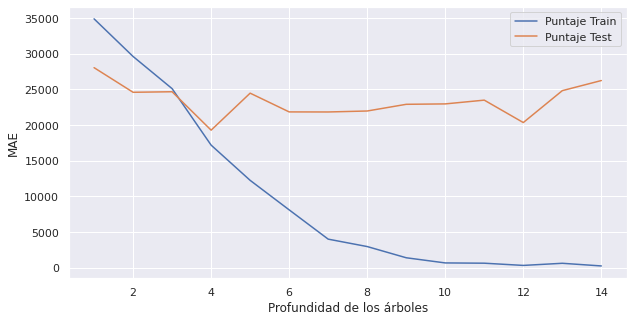

In [70]:
plt.figure(figsize=(10,5))
plt.plot(max_depths,scores_train, label = 'Puntaje Train')
plt.plot(max_depths,scores_test, label = 'Puntaje Test')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Profundidad de los árboles')
plt.show()

Voy a tomar el valor 4, porque tenemos un puntaje bueno para test, que no mejora significativamente con otros valores y la diferencia contra el puntaje en test no es significativa.

In [71]:
ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=4), n_estimators = 50, learning_rate = 0.9)

ada.fit(X_train, y_train)

y_test_pred = ada.predict(X_test)
print('El MAE para el conjunto test es:', mean_absolute_error(y_test, y_test_pred))

y_train_pred = ada.predict(X_train)
print('El MAE para el conjunto train es:', mean_absolute_error(y_train, y_train_pred))

El MAE para el conjunto test es: 24616.44984838327
El MAE para el conjunto train es: 19134.208697819675


In [72]:
ada.feature_importances_

array([0.07441535, 0.06104303, 0.04650297, 0.06514564, 0.05236992,
       0.04674713, 0.17439236, 0.03532529, 0.08493428, 0.05476254,
       0.12201095, 0.18235053])

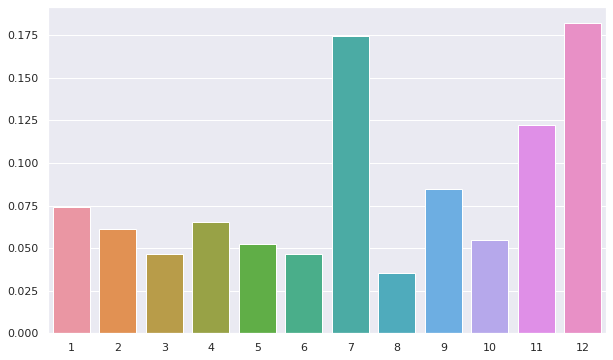

In [73]:
importances = ada.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(1,13,1), y=importances)

Observamos que la importancia de las semanas a la hora de predecir coincide **en parte** con la autocorrelación que habíamos graficado anteriormente.

Vamos a comparar gráificamente la serie original con los valores predichos:

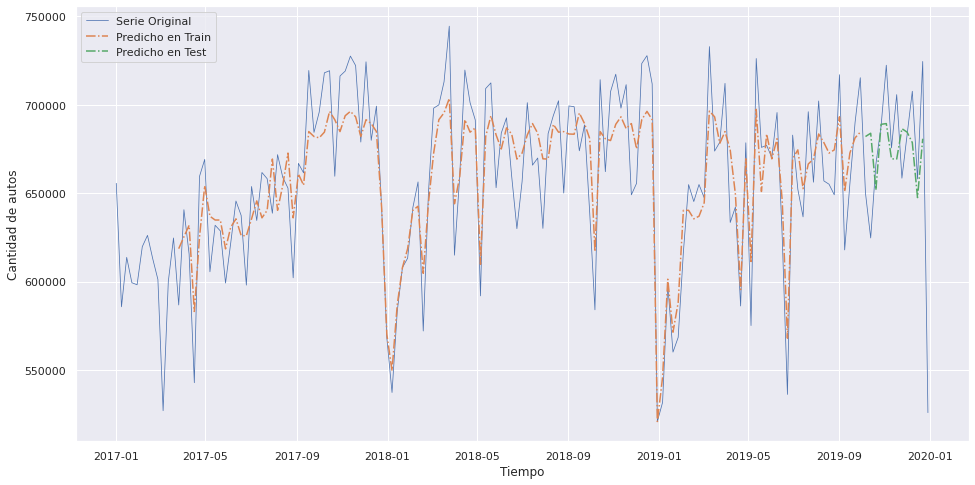

In [74]:
plt.figure(figsize=(16,8))
plt.plot(senial.index, senial, lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[look_back + N_train:-1], y_test_pred,'-.', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



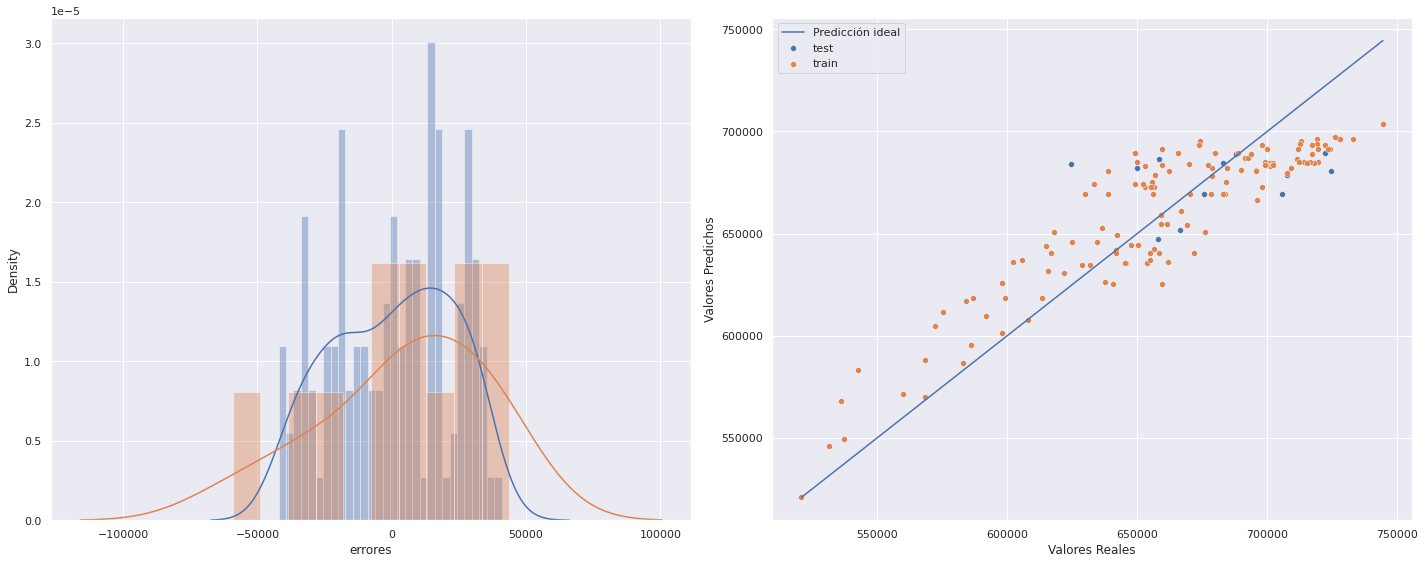

In [75]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 10, label = 'test')
plt.xlabel('errores')

plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_test_pred, label = 'test')
sns.scatterplot(x=y_train, y=y_train_pred, label = 'train')
sns.lineplot(x=y, y=y, label= 'Predicción ideal')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.legend()
plt.tight_layout()

La distribución de errores no se concentra alrededor del cero, lo cual quiere decir que en algunas instancias el modelo se equivocó en un margen mucho mayor. Podemos ver eso también en el segundo gráfico, donde algunos de nuestros puntos se encuentran más alejados de la predicción ideal.
### **MULTI-STEP PREDICTION**
Vamos a utilizar el modelo entrenado y aplicarle el método recursivo para hacer Multi-Step prediction

In [76]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = ada.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

In [77]:
print('El MAE para el conjunto test es:', mean_absolute_error(y_test, y_ms_test_pred))

El MAE para el conjunto test es: 24917.976677025687


Vemos que el rendimiento del modelo empeora.

Graficamos los resultados:

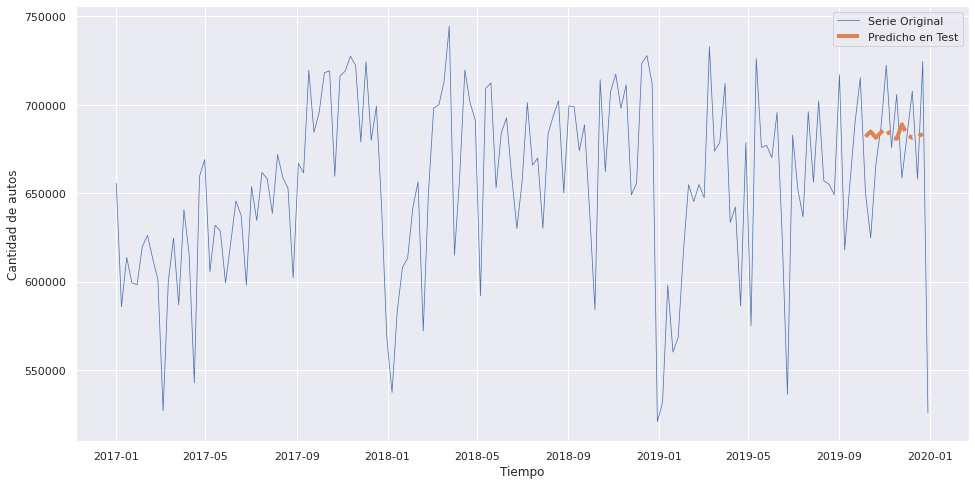

In [78]:
plt.figure(figsize=(16,8))
plt.plot(senial.index, senial, lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[look_back + N_train:-1], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

Vamos a definir un modelo benchmark, para poder comparar los resultados. Voy a utilizar un modelo benchmark muy común en series de tiempo: nuestra predicción será el valor correspondiente al día anterior.

In [79]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [80]:
print('El MAE para el conjunto test es:', mean_absolute_error(y_test, y_test_pred_benchmark))

El MAE para el conjunto test es: 39819.083333333336


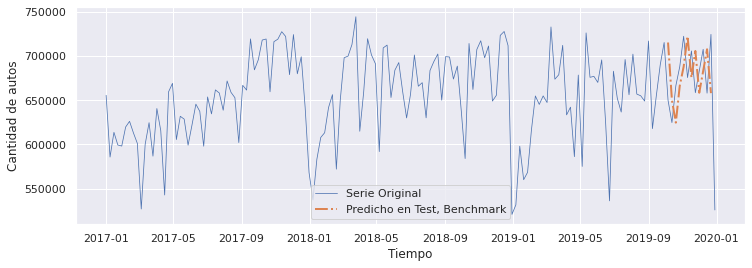

In [81]:
plt.figure(figsize=(12,4))
plt.plot(senial.index, senial,lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back:-1], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.legend()
plt.show()

Si bien no me complacían mucho los resultados en un principio, podemos ver que son mejoradores frente a un modelo simple como el que planteamos arriba.

A continuación, vamos a preparar la serie para entrenar un modelo `Prophet`, que es un algoritmo específico para trabajar con series de tiempo.

Lo primero que debemos hacer es renombrar las columnas como `ds` e `y` y resetear el index.

In [82]:
weekly.reset_index(inplace=True)
weekly.rename(columns={'fecha':'ds', 'cantidad_pasos':'y'}, inplace=True)
weekly

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2017-01-01,655544.0
1,2017-01-08,585700.0
2,2017-01-15,613675.0
3,2017-01-22,599307.0
4,2017-01-29,598163.0
...,...,...
152,2019-12-01,682974.0
153,2019-12-08,707644.0
154,2019-12-15,658014.0
155,2019-12-22,724497.0


Hacemos train-test split.

In [83]:
weekly_train = weekly.iloc[:-12,:]
weekly_test = weekly.iloc[-12:,:]

In [84]:
weekly_train

,ds,y
0,2017-01-01,655544.0
1,2017-01-08,585700.0
2,2017-01-15,613675.0
3,2017-01-22,599307.0
4,2017-01-29,598163.0
...,...,...
140,2019-09-08,617872.0
141,2019-09-15,655191.0
142,2019-09-22,690042.0
143,2019-09-29,715304.0


In [85]:
weekly_test

,ds,y
145,2019-10-13,624643.0
146,2019-10-20,666350.0
147,2019-10-27,687950.0
148,2019-11-03,722382.0
149,2019-11-10,675614.0
150,2019-11-17,705733.0
151,2019-11-24,658474.0
152,2019-12-01,682974.0
153,2019-12-08,707644.0
154,2019-12-15,658014.0


Instanciamos el modelo y le agregamos las "holidays" de Argentina. Esto es para pasarle al modelo ocasiones especiales, como Navidad, Año Nuevo, Pascua, etc.

In [86]:
model = Prophet()
model.add_country_holidays(country_name='Argentina')
model.fit(weekly_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [87]:
model.train_holiday_names

0                            Año Nuevo [New Year's Day]
1                      Día de Carnaval [Carnival's Day]
2     Día Nacional de la Memoria por la Verdad y la ...
3     Semana Santa (Jueves Santo)  [Holy day (Holy T...
4     Semana Santa (Viernes Santo)  [Holy day (Holy ...
5                           Día de Pascuas [Easter Day]
6     Día del Veterano y de los Caidos en la Guerra ...
7                          Día del Trabajo [Labour Day]
8     Día de la Revolucion de Mayo [May Revolution Day]
9     Día Pase a la Inmortalidad del General Martín ...
10    Día Pase a la Inmortalidad del General D. Manu...
11           Día de la Independencia [Independence Day]
12    Día Pase a la Inmortalidad del General D. José...
13    Día del Respeto a la Diversidad Cultural [Resp...
14    Día Nacional de la Soberanía [National Soverei...
15     La Inmaculada Concepción [Immaculate Conception]
16                                  Navidad [Christmas]
dtype: object

In [88]:
future = model.make_future_dataframe(periods=12, freq='W')
future

,ds
0,2017-01-01
1,2017-01-08
2,2017-01-15
3,2017-01-22
4,2017-01-29
...,...
152,2019-12-01
153,2019-12-08
154,2019-12-15
155,2019-12-22


In [89]:
forecast = model.predict(future)
forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,yhat,yhat_lower,yhat_upper
145,661991.811135,619660.543859,702880.499495
146,678722.394471,637830.963924,723475.252874
147,705315.846582,665684.635039,747281.951846
148,718711.905624,677548.713692,761806.054500
149,708311.917985,666856.271440,749865.083877
150,687378.956092,640694.992627,728869.431990
151,678759.376908,633980.143347,717590.188260
152,689813.892818,646578.066103,730563.258030
153,703241.091519,658268.599538,747467.286371
154,693620.518846,649208.444286,736342.805589


In [90]:
print('El MAE para el conjunto train es:', mean_absolute_error(weekly_train.y, forecast.yhat[:145]))
print('El MAE para el conjunto test es:', mean_absolute_error(weekly_test.y, forecast.yhat[145:]))

El MAE para el conjunto train es: 26217.57951823315
El MAE para el conjunto test es: 27821.381818698264


En principio, los resultados del modelo son mejores que los que obtuvimos con el `AdaBoostRegressor`.

Graficamos los resultados:

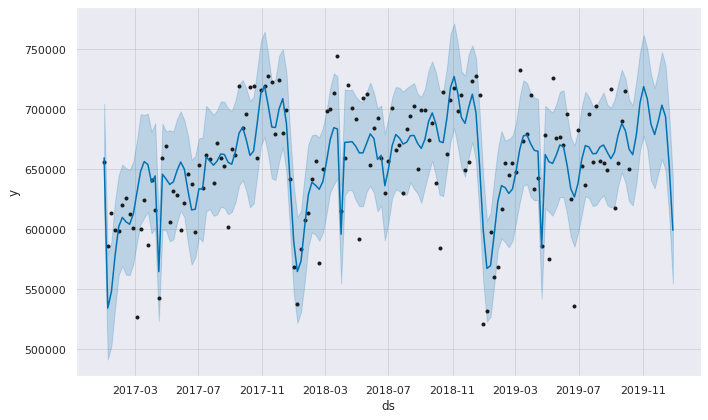

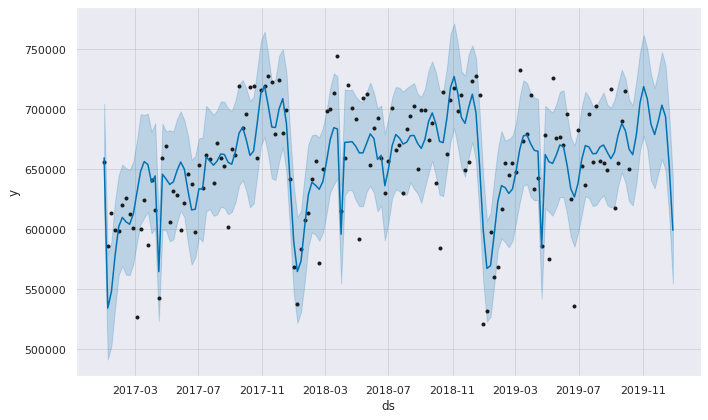

In [91]:
model.plot(forecast)

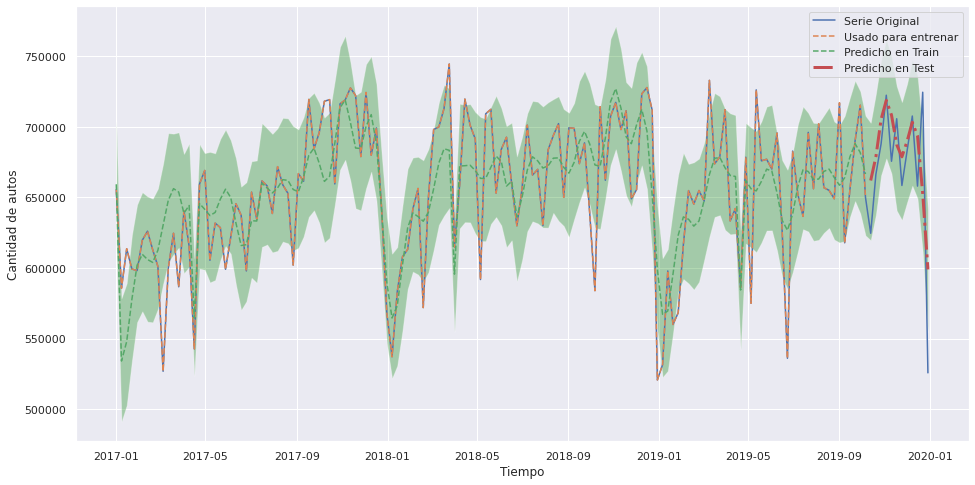

In [92]:
plt.figure(figsize=(16,8))
sns.lineplot(x=weekly.ds, y=weekly.y,lw = 1.5, label = 'Serie Original')
sns.lineplot(x=weekly_train.ds, y=weekly_train.y, label = 'Usado para entrenar', linestyle='--')
plt.fill_between(x=forecast.ds, y1=forecast.yhat_lower, y2=forecast.yhat_upper,facecolor='green', alpha=0.3)
sns.lineplot(x=forecast.ds[:145], y=forecast.yhat[:145],label = 'Predicho en Train', linestyle='--')
sns.lineplot(x=forecast.ds[145:], y=forecast.yhat[145:], lw = 3, label = 'Predicho en Test', linestyle='-.')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.legend()
plt.show()

Podemos ver que el modelo `Prophet` se desempeña ligeramente peor que el modelo de ensamble, aunque por un margen bastante pequeño. A su vez, nos muestra una varianza menor. Para tomar la decisión final, vamos a ver cómo se desempeñan con los datos del primer trimestre del año 2020:

In [93]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0


Podemos ver que a diferencia de los anteriores, este dataset tiene otras columnas, como observación, dia_fecha y mes (lo cual podría ser un indicio de que son variables categóricas de interes a la hora de predecir un flujo)
También podemos ver, a simple vista, que hay columnas que no tienen las mismas categorías que años anteriores, por ejemplo tipo_vehiculo, forma_pago.

Vamos a filtrar por estación para poder comparar con la serie que tenemos.

In [94]:
data_2020.estacion.unique()

array(['ALBERDI', 'AVELLANEDA', 'DELLEPIANE LINIERSLEPIANE CENTRO',
       'DELLEPIANE LINIERS', 'ILLIA', 'ILP', 'PB1', 'PB3', 'PB4',
       'RETIRO', 'SALGUERO', 'SARMIENTO', 'PB2'], dtype=object)

In [95]:
data_2020 = data_2020[data_2020.estacion == 'ILLIA']
data_2020

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
52,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Centro,326.0
53,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319.0
54,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Exento,Exento - Reglamento,Centro,2.0
55,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Exento,Exento - Reglamento,Provincia,1.0
56,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Rec.Deuda,Paso en Infracción,Centro,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533554,2020.0,2020-12-30,diciembre,Miércoles,30.0,17.0,18.0,ILLIA,Pesados 6 Ejes,Tag,Tag - PosPago OCR,Centro,1.0
2533596,2020.0,2020-12-30,diciembre,Miércoles,30.0,21.0,22.0,ILLIA,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,1.0
2533652,2020.0,2020-12-31,diciembre,Jueves,31.0,9.0,10.0,ILLIA,Pesados 6 Ejes,Tag,Tag - PosPago OCR,Provincia,1.0
2533664,2020.0,2020-12-31,diciembre,Jueves,31.0,10.0,11.0,ILLIA,Pesados 6 Ejes,Tag,Tag - PosPago,Provincia,2.0


In [96]:
data_2020.fecha.unique()

array(['2020-01-01 00:00:00', '2020-01-02 00:00:00',
       '2020-01-03 00:00:00', '2020-01-04 00:00:00',
       '2020-01-05 00:00:00', '2020-01-06 00:00:00',
       '2020-01-07 00:00:00', '2020-01-08 00:00:00',
       '2020-01-09 00:00:00', '2020-01-10 00:00:00',
       '2020-01-11 00:00:00', '2020-01-12 00:00:00',
       '2020-01-13 00:00:00', '2020-01-14 00:00:00',
       '2020-01-15 00:00:00', '2020-01-16 00:00:00',
       '2020-01-17 00:00:00', '2020-01-18 00:00:00',
       '2020-01-19 00:00:00', '2020-01-20 00:00:00',
       '2020-01-21 00:00:00', '2020-01-22 00:00:00',
       '2020-01-23 00:00:00', '2020-01-24 00:00:00',
       '2020-01-25 00:00:00', '2020-01-26 00:00:00',
       '2020-01-27 00:00:00', '2020-01-28 00:00:00',
       '2020-01-29 00:00:00', '2020-01-30 00:00:00',
       '2020-01-31 00:00:00', '2020-02-01 00:00:00',
       '2020-02-02 00:00:00', '2020-02-03 00:00:00',
       '2020-02-04 00:00:00', '2020-02-05 00:00:00',
       '2020-02-06 00:00:00', '2020-02-07 00:0

Se puede ver en el output de la celda anterior que las fechas que tienen aclarada la hora, tienen la hora 0, por lo cual no se van a ver afectadas si le sumamos la `hora_inicio` en formato `timedelta`.

In [97]:
fechas = pd.to_datetime(data_2020.fecha)

In [98]:
horas = pd.to_timedelta(data_2020.hora_inicio, unit='h')

In [99]:
data_2020['fecha2'] = fechas + horas
data_2020.sort_values(['fecha2'], inplace=True)
data_2020

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
52,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Centro,326.0,2020-01-01 00:00:00
3918,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Pesados 3 Ejes,Efectivo,Efectivo,Provincia,1.0,2020-01-01 00:00:00
2993,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Pesados 2 Ejes,Tag,Tag - PrePago,Centro,1.0,2020-01-01 00:00:00
2992,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Pesados 2 Ejes,Tag,Tag - PosPago OCR,Provincia,2.0,2020-01-01 00:00:00
2991,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Pesados 2 Ejes,Tag,Tag - PosPago,Provincia,6.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445483,2020.0,2020-12-31,diciembre,Jueves,31.0,23.0,0.0,ILLIA,Auto,Mercado Pago,Mercado Pago,Provincia,1.0,2020-12-31 23:00:00
2445482,2020.0,2020-12-31,diciembre,Jueves,31.0,23.0,0.0,ILLIA,Auto,Mercado Pago,Mercado Pago,Centro,4.0,2020-12-31 23:00:00
2470775,2020.0,2020-12-31,diciembre,Jueves,31.0,23.0,0.0,ILLIA,N/D,Violación,Violación - Normal,Centro,52.0,2020-12-31 23:00:00
2445489,2020.0,2020-12-31,diciembre,Jueves,31.0,23.0,0.0,ILLIA,Auto,Tag,Tag - PosPago OCR,Provincia,12.0,2020-12-31 23:00:00


In [100]:
data_2020.drop(columns=['fecha', 'periodo', 'hora_fin', 'estacion'], inplace=True)
data_2020.reset_index(drop=True, inplace=True)
data_2020

,mes,dia,dia_fecha,hora_inicio,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
0,enero,Miércoles,1.0,0.0,Auto,Efectivo,Efectivo,Centro,326.0,2020-01-01 00:00:00
1,enero,Miércoles,1.0,0.0,Pesados 3 Ejes,Efectivo,Efectivo,Provincia,1.0,2020-01-01 00:00:00
2,enero,Miércoles,1.0,0.0,Pesados 2 Ejes,Tag,Tag - PrePago,Centro,1.0,2020-01-01 00:00:00
3,enero,Miércoles,1.0,0.0,Pesados 2 Ejes,Tag,Tag - PosPago OCR,Provincia,2.0,2020-01-01 00:00:00
4,enero,Miércoles,1.0,0.0,Pesados 2 Ejes,Tag,Tag - PosPago,Provincia,6.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
296048,diciembre,Jueves,31.0,23.0,Auto,Mercado Pago,Mercado Pago,Provincia,1.0,2020-12-31 23:00:00
296049,diciembre,Jueves,31.0,23.0,Auto,Mercado Pago,Mercado Pago,Centro,4.0,2020-12-31 23:00:00
296050,diciembre,Jueves,31.0,23.0,N/D,Violación,Violación - Normal,Centro,52.0,2020-12-31 23:00:00
296051,diciembre,Jueves,31.0,23.0,Auto,Tag,Tag - PosPago OCR,Provincia,12.0,2020-12-31 23:00:00


In [101]:
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True)
data_2020.drop(columns=['tipo_vehiculo', 'forma_pago', 'observacion', 'sentido'], inplace=True)
data_2020 = data_2020.groupby(by=['fecha', 'hora_inicio', 'dia', 'dia_fecha', 'mes']).sum()
data_2020.reset_index(inplace=True)
data_2020

,fecha,hora_inicio,dia,dia_fecha,mes,cantidad_pasos
0,2020-01-01 00:00:00,0.0,Miércoles,1.0,enero,1228.0
1,2020-01-01 01:00:00,1.0,Miércoles,1.0,enero,642.0
2,2020-01-01 02:00:00,2.0,Miércoles,1.0,enero,388.0
3,2020-01-01 03:00:00,3.0,Miércoles,1.0,enero,374.0
4,2020-01-01 04:00:00,4.0,Miércoles,1.0,enero,671.0
...,...,...,...,...,...,...
8779,2020-12-31 19:00:00,19.0,Jueves,31.0,diciembre,2602.0
8780,2020-12-31 20:00:00,20.0,Jueves,31.0,diciembre,2830.0
8781,2020-12-31 21:00:00,21.0,Jueves,31.0,diciembre,1865.0
8782,2020-12-31 22:00:00,22.0,Jueves,31.0,diciembre,480.0


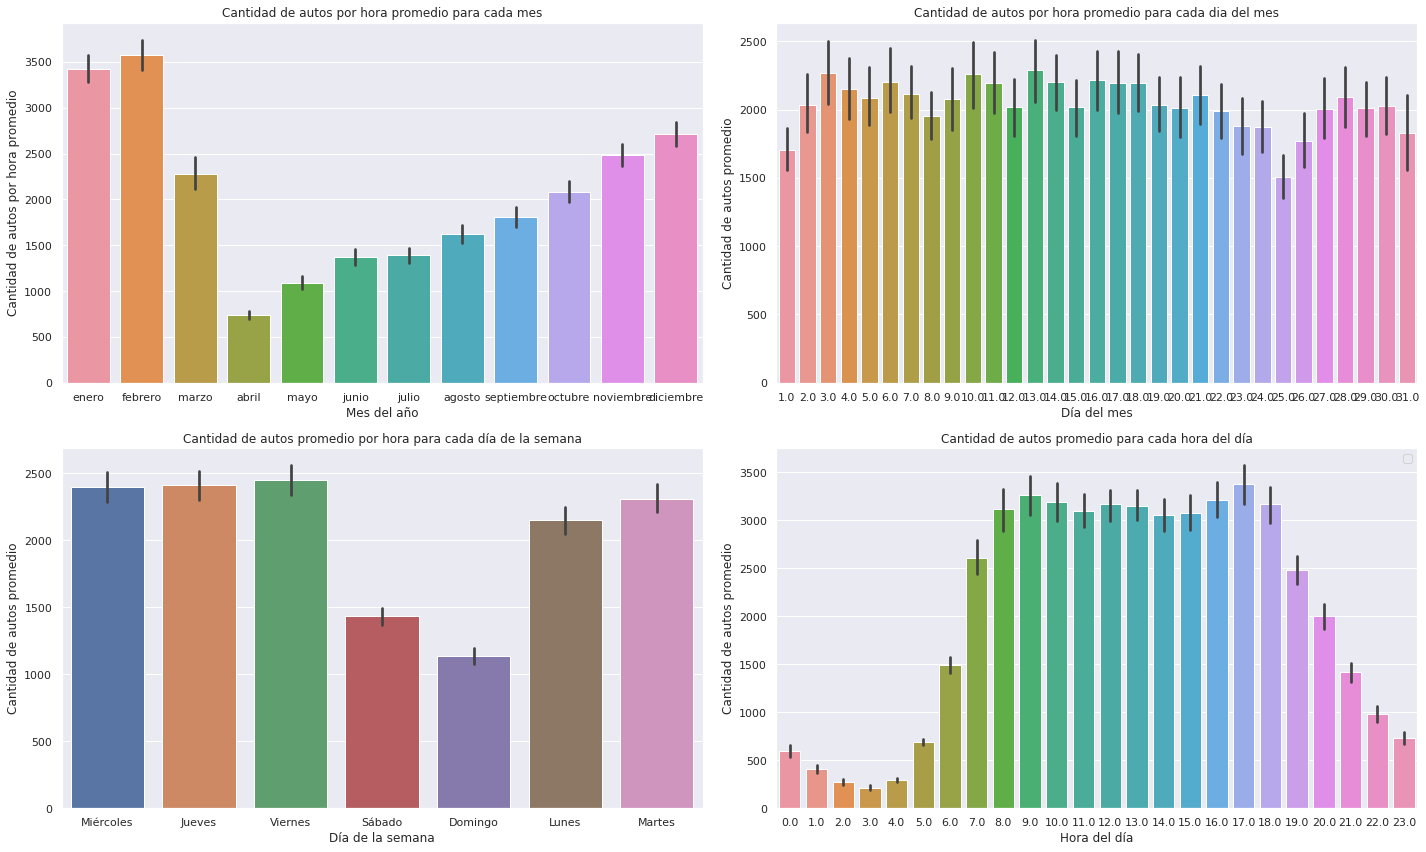

In [102]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(data=data_2020, x='mes', y='cantidad_pasos')
plt.xlabel('Mes del año')
plt.ylabel('Cantidad de autos por hora promedio')
plt.title('Cantidad de autos por hora promedio para cada mes')

plt.subplot(2,2,2)
sns.barplot(data=data_2020, x='dia_fecha', y='cantidad_pasos')
plt.xlabel('Día del mes')
plt.ylabel('Cantidad de autos promedio')
plt.title('Cantidad de autos por hora promedio para cada dia del mes')

plt.subplot(2,2,3)
sns.barplot(data=data_2020, x='dia', y='cantidad_pasos')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de autos promedio')
plt.title('Cantidad de autos promedio por hora para cada día de la semana')

plt.subplot(2,2,4)
sns.barplot(data=data_2020, x='hora_inicio', y='cantidad_pasos')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de autos promedio')
plt.title('Cantidad de autos promedio para cada hora del día')

plt.legend()
plt.tight_layout()
plt.show()

Podemos ver que para hora del dia y dia de la semana, tenemos un comportamiento parecido (en terminos de distribución de los datos, no de cantidad absoluta de vehículos). En los gráficos superiores podemos ver, por un lado el efecto de las restricciones de circulación por la pandemia COVID-19, y por otro lado tenemos una categoría nueva: cada día del mes. En este caso se superponen los intervalos de confianza (std) pero podemos ver que, en promedio, hay días del mes donde el tráfico se intensifica, lo cual también podría ayudarnos a predecir el flujo.

Luego de este brevísimo EDA, vamos a chequear nuevamente que nuestra serie 2020 no tenga gaps:

In [103]:
24*366 - data_2020.shape[0]

0

In [104]:
data_2020.drop(columns=['hora_inicio', 'dia', 'dia_fecha', 'mes'], inplace=True)
data_2020.describe()

,cantidad_pasos
count,8784.000000
mean,2044.639344
std,1832.511045
min,5.000000
25%,472.000000
50%,1477.500000
75%,3232.250000
max,8740.000000


In [105]:
data_2020 = data_2020.resample('W', on = 'fecha').sum()
data_2020.reset_index(inplace=True)
data_2020 = data_2020[1:11] #tiramos la primer semana porque está incompleta
data_2020

,fecha,cantidad_pasos
1,2020-01-12,578943.0
2,2020-01-19,588503.0
3,2020-01-26,576175.0
4,2020-02-02,603931.0
5,2020-02-09,605694.0
6,2020-02-16,631479.0
7,2020-02-23,628348.0
8,2020-03-01,550724.0
9,2020-03-08,657997.0
10,2020-03-15,595102.0


In [106]:
last_week = last_week.rename(columns={'fecha' : 'ds', 'cantidad_pasos' : 'y'})
last_week

,ds,y
157,2020-01-05,655544.0


In [107]:
data_2020.rename(columns={'fecha' : 'ds', 'cantidad_pasos' : 'y'}, inplace=True)
data_2020_ada = pd.concat([weekly.iloc[-13:,:], last_week, data_2020]) #agregamos suficientes instancias para poder predecir el primer trimestre 2020
data_2020_ada.reset_index(drop=True, inplace=True)
data_2020_ada

,ds,y
0,2019-10-06,650000.0
1,2019-10-13,624643.0
2,2019-10-20,666350.0
3,2019-10-27,687950.0
4,2019-11-03,722382.0
5,2019-11-10,675614.0
6,2019-11-17,705733.0
7,2019-11-24,658474.0
8,2019-12-01,682974.0
9,2019-12-08,707644.0


In [108]:
look_back = 12 
senial = data_2020_ada.y
N = senial.shape[0]
X_2020 = np.zeros((N - look_back - 1,look_back))
y_2020 = np.zeros(N - look_back - 1)
print(X_2020.shape, y_2020.shape)

(11, 12) (11,)


In [109]:
for i in range(X_2020.shape[0]):
  X_2020[i,:] = senial.iloc[i+1:i+look_back+1]
  y_2020[i] = senial.iloc[i+look_back+1]

In [110]:
y_2020

array([655544., 578943., 588503., 576175., 603931., 605694., 631479.,
       628348., 550724., 657997., 595102.])

In [111]:
X_2020

array([[624643., 666350., 687950., 722382., 675614., 705733., 658474.,
        682974., 707644., 658014., 724497., 525807.],
       [666350., 687950., 722382., 675614., 705733., 658474., 682974.,
        707644., 658014., 724497., 525807., 655544.],
       [687950., 722382., 675614., 705733., 658474., 682974., 707644.,
        658014., 724497., 525807., 655544., 578943.],
       [722382., 675614., 705733., 658474., 682974., 707644., 658014.,
        724497., 525807., 655544., 578943., 588503.],
       [675614., 705733., 658474., 682974., 707644., 658014., 724497.,
        525807., 655544., 578943., 588503., 576175.],
       [705733., 658474., 682974., 707644., 658014., 724497., 525807.,
        655544., 578943., 588503., 576175., 603931.],
       [658474., 682974., 707644., 658014., 724497., 525807., 655544.,
        578943., 588503., 576175., 603931., 605694.],
       [682974., 707644., 658014., 724497., 525807., 655544., 578943.,
        588503., 576175., 603931., 605694., 631479.],


In [112]:
y_test_pred_2020 = ada.predict(X_2020)
print('El MAE para el conjunto test es:', mean_absolute_error(y_2020, y_test_pred_2020))

El MAE para el conjunto test es: 41129.178200965696


In [113]:
data_2020 = pd.concat([last_week, data_2020])
data_2020.reset_index(drop=True, inplace=True)
data_2020

,ds,y
0,2020-01-05,655544.0
1,2020-01-12,578943.0
2,2020-01-19,588503.0
3,2020-01-26,576175.0
4,2020-02-02,603931.0
5,2020-02-09,605694.0
6,2020-02-16,631479.0
7,2020-02-23,628348.0
8,2020-03-01,550724.0
9,2020-03-08,657997.0


In [114]:
future = model.make_future_dataframe(periods=23, freq='W')
future.tail(15)

,ds
153,2019-12-08
154,2019-12-15
155,2019-12-22
156,2019-12-29
157,2020-01-05
158,2020-01-12
159,2020-01-19
160,2020-01-26
161,2020-02-02
162,2020-02-09


In [115]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

,ds,yhat,yhat_lower,yhat_upper
157,2020-01-05,561843.770316,516360.786575,604539.442493
158,2020-01-12,558280.975280,517062.054836,599970.294705
159,2020-01-19,581676.608502,537177.373864,624758.474520
160,2020-01-26,610503.889788,566159.222836,654427.005466
161,2020-02-02,626589.350105,580183.066858,668876.880922
162,2020-02-09,626885.650715,587231.837126,673057.056477
163,2020-02-16,621601.917277,580327.571946,664949.497659
164,2020-02-23,623230.414015,575961.209617,663793.261613
165,2020-03-01,636246.159465,593783.253308,680624.829102
166,2020-03-08,654631.615787,609099.642625,696242.611197


In [116]:
print('El MAE para el conjunto test es:', mean_absolute_error(data_2020.y, forecast.yhat[157:]))

El MAE para el conjunto test es: 34182.696871222164


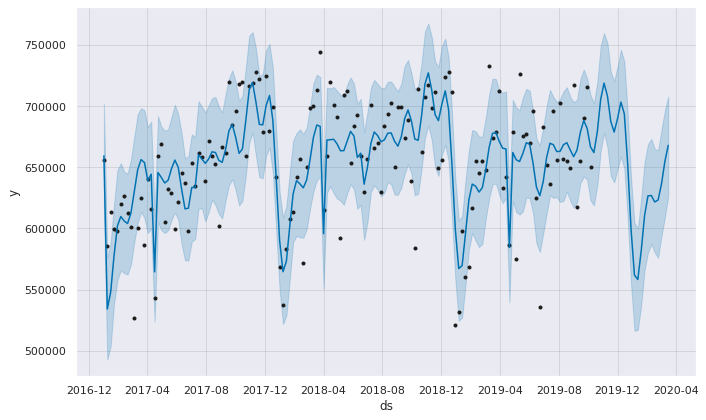

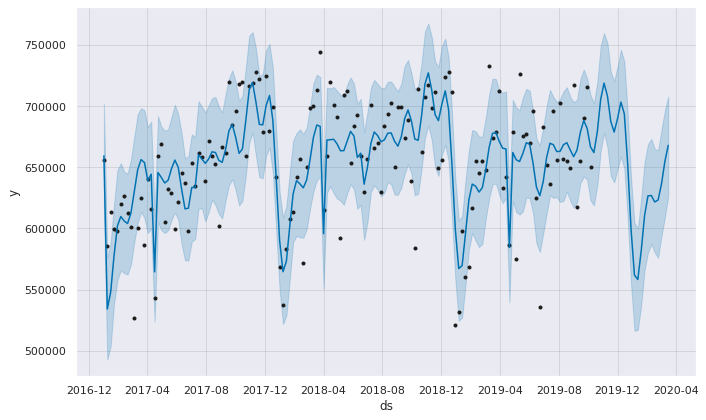

In [117]:
model.plot(forecast)

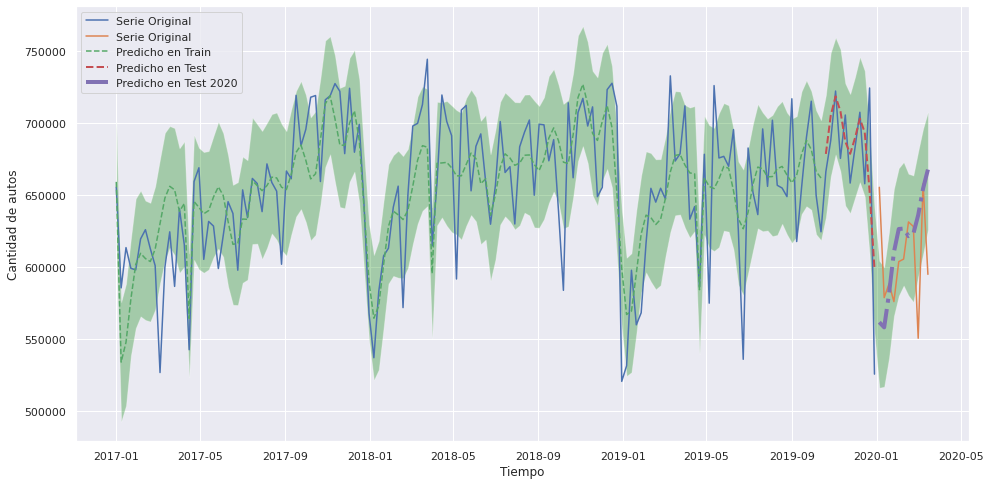

In [118]:
plt.figure(figsize=(16,8))
sns.lineplot(x=weekly.ds, y=weekly.y,lw = 1.5, label = 'Serie Original')
sns.lineplot(x=data_2020.ds, y=data_2020.y,lw = 1.5, label = 'Serie Original')
plt.fill_between(x=forecast.ds, y1=forecast.yhat_lower, y2=forecast.yhat_upper,facecolor='green', alpha=0.3)
sns.lineplot(x=forecast.ds[:146], y=forecast.yhat[:146],label = 'Predicho en Train', linestyle='--')
sns.lineplot(x=forecast.ds[146:157], y=forecast.yhat[146:157], lw = 2, label = 'Predicho en Test', linestyle='--')
sns.lineplot(x=forecast.ds[157:], y=forecast.yhat[157:], lw = 4, label = 'Predicho en Test 2020', linestyle='-.')
plt.plot()
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

##**CONCLUSIONES**
Si bien nuestro `AdaBoostRegressor` había tenido un desempeño ligeramente mejor con los datos del 2019, vemos que con los datos del 2020, el modelo `Prophet` hace una predicción mucho más acertada.

La mejor elección de un modelo para este problema sería el modelo `Prophet`.
* Tuvo un mejor desempeño con los datos del 2020.
* Al ser una librería diseñada para trabajar con series de tiempo, tenemos funciones complementarias que nos permiten trabajar mejor con las predicciones (por ejemplo la función que usamos para pasarle al modelo los feriados en Argentina).
* Nos provee de un intervalo de confianza(`yhat_upper` y `yhat_lower`).
* También tiene una muy buena función para plotear, que nos permite visualizar la función definida por el algoritmo para predecir registros futuros, en contraparte con otros modelos, donde debemos generar las gráficas manualmente.
* El modelo tenía mucha menos varianza que el modelo de ensamble (el cual está diseñado para controlar la varianza).

Tomando todo esto en cuenta, creo que el modelo se desempeñó bastante bien con un grupo de datos con mucha varianza, sin variables auxiliares que ayudaran en la predicción.

##**INVESTIGACIÓN**
En vista de todo lo desarrollado hasta aquí en este proyecto, no puedo evitar la siguiente pregunta: ¿y las variables categóricas? A lo largo del notebook, salvando el análisis exploratorio de datos, solo trabjamos con la variable *tiempo*, mientras que nuestro *target* era la cantidad de vehículos contabilizados en un lapso determinado. Pero como hemos visto e investigado en los dos proyectos anteriores, los modelos pueden usar toda clase de información para formular sus predicciones. De hecho, hemos **confirmado** que modelos como el `AdaBoostRegressor` o `RandomForestRegressor` tienen un desempeño mucho mejor cuando le pasamos datasets con muchos features.¿Cómo podríamos pasarle, por ejemplo, información sobre día de la semana, mes del año, etc. a nuestro modelo `AdaBoostRegressor`?¿Y al modelo `Prophet`?¿Mejorarían los resultados con este tipo de información?¿En qué medida? Pudiendo agregar este tipo de información, ¿sería conveniente trabajar con otra frecuencia de registros? Si bien elegimos la frecuencia semanal por el componente residual, vimos que tanto la frecuencia diaria como la horaria, tenían patrones de correlación mucho más cíclicos, tal vez más fáciles de reproducir para un modelo, si le pasamos la información correcta.

### **PASANDO DEL *¿QUÉ?* AL *¿CÓMO?***
En este párrafo voy a desarrollar un flujo de trabajo que me permita añadir columnas con información auxiliar sobre día de la semana.
1. `AdaBoostRegressor`
* Para empezar, vamos a trabajar con la frecuencia diaria.
* Cuando generamos los arrays vacíos para rellenar con la información *target* del look-back, vamos a generar 7 columnas adicionales, correspondientes a cada día de la semana.
* Por último, en un bucle `for`, vamos a rellenar esas columnas con 0 y 1, convirtiéndolas en variables *dummy*. Es decir, si la fila corresponde a un registro de un día Lunes, luego de todas las columnas con los registros del look-back, vamos a tener un `1` en la columna *Lunes*, y 6 `0` en las columnas correspondientes a los demás días de la semana. Sabiendo qué día de la semana es nuestro primer registro, sabremos en qué orden rellenar dichas columnas.
2. `Prophet`
Para nuestro modelo Prophet, trabajaremos sobre el dataset original con un procedimiento parecido. Además debemos trabajar sobre el DataFrame que creamos con la función `make_future_dataframe`, dado que es el elemento sobre el cual trabajamos con la función `predict`. Vamos a llamarlo `future`.
* Para este modelo, también vamos a trabajar con frecuencia diaria.
* Vamos a definir 7 funciones, una para cada día de la semana, para luego aplicarlas en su columna correspondiente.
* Creamos 7 columnas nuevas y les aplicamos su funcion correspondiente. Así nos quedaran columnas con datos `booleanos`.
* Le pasamos esta nueva estacionalidad que creamos al modelo con la función `add_seasonality` y especificamos en el parámetro `condition_name` el nombre de cada columna. Repetimos la función para cada dia de la semana.
* Por último, le agregamos dichas columnas al dataframe `future`, aplicando la función correspondiente sobre la columna `ds` (contiene las fechas)